# Задача:
https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/ 
ДЗ - оценить возраст человека по изображению. В качестве датасета возьмите датасет только лиц. 
Предположим что сами лица вы находить и извлекать уже умеете. Можете сделать это как продолжение решения по поиску лиц из предыдущих работ.
https://www.google.com/amp/s/www.geeksforgeeks.org/age-detection-using-deep-learning-in-opencv/amp/ пример того как это может работать.  
В качестве фьючеэкстрактора берите любую современную нейронную сеть. Задачу можно решать как задачу регрессии или классификации.  14 14-18 
Если есть время можете попробовать 2 способа.  Попробуйте разблокировать часть слоев после обучения и дообучить модель.


0-14 14-17 18-21 22-


Указание -  что бы решить задачу регресси вам нужно использовать flow_from_dataframe
Указание - для начала вам нужно создать датафрейм в котором будет относительный путь к изображению и целевая метка, потом использовать этот датафрейм при обучении

In [2]:
from keras import models
from keras import optimizers
from keras import layers
from keras.metrics import AUC
from matplotlib import pyplot as plt
import numpy as np
import tarfile
import pandas as pd
import random
import mediapipe as mp
from tqdm import tqdm
import os, shutil
import math
import cv2

In [2]:
# fname = 'notMNIST_small.tar.gz'    # распаковываем данные
# if fname.endswith("tar.gz"):
#     tar = tarfile.open(fname, "r:gz")
#     tar.extractall()
#     tar.close()

In [2]:
base_dir = './wiki_crop'   # директорий для сохранения выделенного небольшого набора данных
cropped_imgs = './wiki_crop/cropped_imgs'

In [3]:
folders = os.listdir(f'{base_dir}')

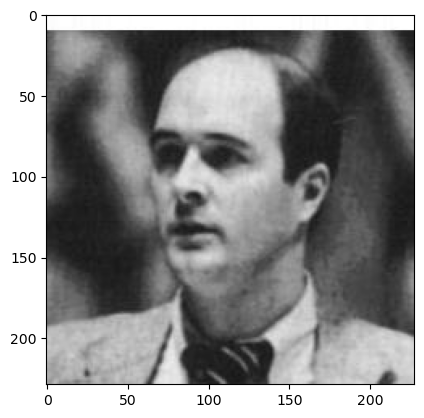

In [4]:
img = cv2.imread("./wiki_crop/01/10075401_1944-11-05_1982.jpg")    # смотрим вид изображения
plt.imshow(img)
plt.show()

In [5]:
#Обнаружение лиц на изображениях
from mtcnn import MTCNN
import cv2

def detect_faces(image_path):
    detector = MTCNN()
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    faces = detector.detect_faces(image)
    return faces, image

In [ ]:
import re
imgs = []
faces = []
labels = []  
os.makedirs(cropped_imgs, exist_ok=True)
for folder in tqdm(folders, desc="Сropped_imgs"):
    folder_path = os.path.join(base_dir, folder)
    
    for img_name in os.listdir(folder_path):
        if not img_name.endswith('.jpg'):
            continue
            
        img_path = os.path.join(folder_path, img_name)
        
        try:
            detected_faces, image = detect_faces(img_path)
            
            if not detected_faces:
                continue
                
            # Извлекаем годы из имени файла
            years = re.findall(r'_(\d{4})', img_name)
            if len(years) < 2:
                continue
                
            birth_year, target_year = int(years[0]), int(years[1])
            age = target_year - birth_year
            
            # Обрабатываем каждое обнаруженное лицо
            for i, face in enumerate(detected_faces):
                # Изменяем размер изображения
                resized_img = cv2.resize(image, (224, 224))
                
                # Сохраняем обработанное изображение
                base_name = os.path.splitext(img_name)[0]
                cropped_imgs_name = f"{base_name}_face{i}.jpg"
                cropped_imgs_path = os.path.join(cropped_imgs, cropped_imgs_name)
                cv2.imwrite(cropped_imgs_path, cv2.cvtColor(resized_img, cv2.COLOR_RGB2BGR))
                
                # Добавляем в списки для дальнейшей обработки
                imgs.append(resized_img)
                labels.append(age)
                
        except Exception as e:
            print(f"ERROR processing {img_path}: {str(e)}")
            continue

# Преобразуем в numpy array и нормализуем
if imgs:
    imgs = np.array(imgs).astype('float32') / 255.0
    labels = np.array(labels)
else:
    print("No images were processed!")
    imgs = np.array([])
    labels = np.array([])

In [ ]:
#Использование MTCNN не увенчалось успехом. Было благополучно потрачено 1.5 дня.
#Прервал через 1043m :(
#Сropped_imgs:  34%|███▍      | 34/100 [17:23:04<33:44:47, 1840.73s/it]

In [101]:
# initialize constants
FOLDER_PATH = './wiki_crop'
CROPPED_IMGS_FOLDER = 'cropped_imgs'

INPUT_SHAPE = (128, 128, 3,)
SIZE_TH = 0.25
TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.1
BATCH_SIZE = 32
cropped_imgs_path = os.path.join(FOLDER_PATH, CROPPED_IMGS_FOLDER)

In [ ]:
#imgs_df = pd.read_csv("./imgs_df.csv")

In [ ]:
# Используем Mediapipe
imgs_df = pd.DataFrame(columns=['filename', 'raw', 'class'])

if not os.path.exists(cropped_imgs_path):
    os.mkdir(cropped_imgs_path)

with mp.solutions.face_detection.FaceDetection(
    min_detection_confidence=0.6, model_selection=1) as face_model:

    for num_folder in tqdm(os.listdir(FOLDER_PATH)):
        num_folder_path = os.path.join(FOLDER_PATH, num_folder)

        if not os.path.isdir(num_folder_path):
            continue

        for img_name in os.listdir(num_folder_path):
            img = cv2.imread(os.path.join(num_folder_path, img_name),
                             cv2.IMREAD_COLOR_RGB)
            try:
                imgh, imgw, _ = img.shape
            except AttributeError:
                continue
            try:
                birth_year, photo_year = img_name.split('_')[1:]
                birth_year = int(birth_year.split('-')[0])
                photo_year = int(photo_year.split('.')[0])
                crop_class = photo_year - birth_year
            
                if crop_class <= 0 or crop_class >= 100:
                 continue

                result = face_model.process(img)
                if not result.detections:
                    continue

                for (n, detection) in enumerate(result.detections):
                    bbox = detection.location_data.relative_bounding_box
                    xmin = math.floor(bbox.xmin * imgw)
                    ymin = math.floor(bbox.ymin * imgh)
                    width = math.ceil(bbox.width * imgw)
                    height = math.ceil(bbox.height * imgh)

                    if width / INPUT_SHAPE[0] > SIZE_TH and \
                     height / INPUT_SHAPE[1] > SIZE_TH:
                        continue

                    cropped_img = img[ymin:ymin + height, xmin:xmin + width]
                    if cropped_img.shape == () or 0 in cropped_img.shape:
                        continue
                    resize_img = cv2.resize(cropped_img, (128, 128))

                    cropped_name = f'{num_folder}_{img_name.split(".")[0]}{n}.jpg'
                    cv2.imwrite(os.path.join(FOLDER_PATH, CROPPED_IMGS_FOLDER, cropped_name),
                              cv2.cvtColor(resize_img, cv2.COLOR_RGB2BGR))

                    if imgs_df.empty:
                        imgs_df = pd.DataFrame(dict(zip(imgs_df.columns,
                        [cropped_name, crop_class, np.log(crop_class)])), index=[0])
                    else:
                        imgs_df = imgs_df._append(pd.Series(dict(zip(imgs_df.columns,
                        [cropped_name, crop_class, np.log(crop_class)]))), ignore_index=True)
            except:
                print("Error")
                continue

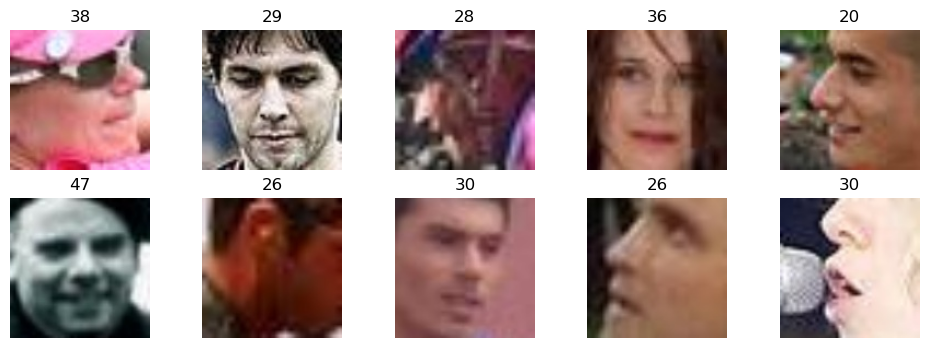

In [41]:
# show cropped images from dataset
plt.figure(figsize=(12, 4))

for i in range(10):
    img_path = os.path.join(FOLDER_PATH, CROPPED_IMGS_FOLDER,
                            imgs_df.loc[i, 'filename'])
    img = cv2.imread(img_path, cv2.IMREAD_COLOR_RGB)

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(str(imgs_df.loc[i, 'raw']))
    plt.axis('off')

In [ ]:
""" #Создадим датафрейм с данными картинок для обучения
imgs = []
for filename in imgs_df["filename"]:        
    try:    # если удалось прочитать 
      image = cv2.imread(cropped_imgs_path + f"/{filename}")
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Преобразуем BGR в RGB
      imgs.append(image)  # Добавляем изображение               
    except:   # если возникла ошибка при чтении
      print("Error")     # выводим название изображение, которое не удалось прочитать
      continue
imgs = np.array(imgs).astype('float32')/255.    # масштабируем признаки """

In [6]:
# Категоризация
def to_categorical(raws):
    # Определяем границы категорий
    bounds = [
        (0, 12),    # 0
        (13, 18),   # 1
        (19, 21),   # 2
        (22, 30),   # 3
        (31, 40),   # 4
        (41, 50),   # 5
        (51, 65),   # 6
        (66, 70),   # 7
        (71, 80),   # 8
        (81, 100)   # 9
    ]
    
        
    categories = []
    for raw in raws:
        # Проверяем, что значение в допустимом диапазоне
        if not 0 <= raw <= 100:
            print("Недопустимый возраст!")
            continue
        
        # Находим правильную категорию
        for category_num, (lower, upper) in enumerate(bounds):
            if lower <= raw <= upper:
                categories.append(category_num)
                break
    
    return categories

In [10]:
labels = to_categorical(imgs_df["raw"])
imgs_df["class"] = labels
imgs_df

,filename,raw,class
0,00_102100_1970-10-09_20080.jpg,38,4
1,00_1024100_1982-06-07_20110.jpg,29,3
2,00_11328300_1980-06-10_20080.jpg,28,3
3,00_1199800_1976-04-13_20120.jpg,36,4
4,00_12318000_1988-06-12_20080.jpg,20,2
...,...,...,...
6201,99_6986299_1986-05-08_20121.jpg,26,3
6202,99_7319399_1981-08-23_20100.jpg,29,3
6203,99_8419699_1973-07-02_20140.jpg,41,5
6204,99_8551399_1972-02-25_20080.jpg,36,4


In [ ]:
#Сохраним датафрейм в файл
import pandas as pd
imgs_df.to_csv("imgs_df.csv", index=False)

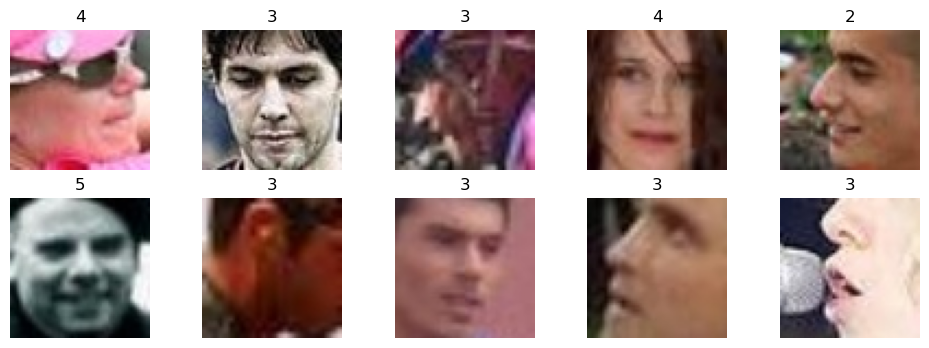

In [ ]:
# show cropped images from dataset
plt.figure(figsize=(12, 4))

for i in range(10):
    img_path = os.path.join(FOLDER_PATH, CROPPED_IMGS_FOLDER,
                            imgs_df.loc[i, 'filename'])
    img = cv2.imread(img_path, cv2.IMREAD_COLOR_RGB)

    plt.subplot(2, 5, i + 1)
    plt.imshow(imgs[i])
    plt.title(str(labels[i]))
    plt.axis('off')

In [33]:
imgs_df["class"] = labels
imgs_df

,filename,raw,class
0,00_102100_1970-10-09_20080.jpg,38,4
1,00_1024100_1982-06-07_20110.jpg,29,3
2,00_11328300_1980-06-10_20080.jpg,28,3
3,00_1199800_1976-04-13_20120.jpg,36,4
4,00_12318000_1988-06-12_20080.jpg,20,2
...,...,...,...
6214,cropped_imgs1_7533707_1961-10-29_20081.jpg,47,5
6215,cropped_imgs1_7739200_1962-05-19_20151.jpg,53,6
6216,cropped_imgs1_934602_1913-05-27_19401.jpg,27,3
6217,cropped_imgs1_934602_1913-05-27_19402.jpg,27,3


In [98]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Разделение данных на train/val/test
train_df, test_df = train_test_split(imgs_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)
print('Train set size is', len(train_df),
      '\nValidation set size is', len(val_df),
      '\nTest set size is', len(test_df))

Train set size is 3723 
Validation set size is 1241 
Test set size is 1242


In [140]:
#Создание генераторов изображений
train_datagen = ImageDataGenerator(
    rotation_range=20,
    brightness_range=(-0.2, 0.2),
    zoom_range=0.3,
    channel_shift_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=os.path.join(FOLDER_PATH, CROPPED_IMGS_FOLDER),
    target_size = INPUT_SHAPE[:2],
    class_mode='raw',
    batch_size=BATCH_SIZE,
    validate_filenames=False
)

val_generator = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=os.path.join(FOLDER_PATH, CROPPED_IMGS_FOLDER),
    target_size = INPUT_SHAPE[:2],
    class_mode='raw',
    batch_size=BATCH_SIZE,
    validate_filenames=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=os.path.join(FOLDER_PATH, CROPPED_IMGS_FOLDER),
    target_size = INPUT_SHAPE[:2],
    class_mode='raw',
    batch_size=BATCH_SIZE,
    validate_filenames=False,
    shaffle=False
)

Found 3723 non-validated image filenames.
Found 1241 non-validated image filenames.
Found 1242 non-validated image filenames.


In [143]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
import tensorflow as tf

# Создание модели
base_model = EfficientNetB0(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

model = models.Sequential([
    base_model,    
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='relu')
])


In [144]:
model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 4,008,829 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [147]:
# Компиляция

import keras
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mse', metrics=['mse'])

model_path = os.path.join(FOLDER_PATH, 'best_model.keras')
chekpointer = ModelCheckpoint(model_path, save_best_only=True,
                              monitor='val_loss', mode='min')

lr_reducing = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                patience=5, mode='min')


early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,
                                                  restore_best_weights=True)


In [148]:

# Обучение

EPOCHS = 20
history = model.fit(train_generator, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    callbacks=[chekpointer, early_stopping_cb, lr_reducing],
                    validation_data=val_generator)

Epoch 1/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 88s 604ms/step - loss: 2.5723 - mse: 2.5723 - val_loss: 0.6501 - val_mse: 0.6501 - learning_rate: 0.0010
Epoch 2/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 68s 585ms/step - loss: 0.2491 - mse: 0.2491 - val_loss: 0.2520 - val_mse: 0.2520 - learning_rate: 0.0010
Epoch 3/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 85s 729ms/step - loss: 0.2081 - mse: 0.2081 - val_loss: 0.1920 - val_mse: 0.1920 - learning_rate: 0.0010
Epoch 4/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 126s 590ms/step - loss: 0.2049 - mse: 0.2049 - val_loss: 0.3750 - val_mse: 0.3750 - learning_rate: 0.0010
Epoch 5/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 68s 580ms/step - loss: 0.1760 - mse: 0.1760 - val_loss: 30.0354 - val_mse: 30.0354 - learning_rate: 0.0010
Epoch 6/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 83s 707ms/step - loss: 0.1838 - mse: 0.1838 - val_loss: 0.3870 - val_mse: 0.3870 - learning_rate: 0.0010
Epoch 7/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 91s 776ms/step - loss: 0.1794 - mse: 0.1794 - val_loss: 0.4699 - val_mse: 0.4699 - lear

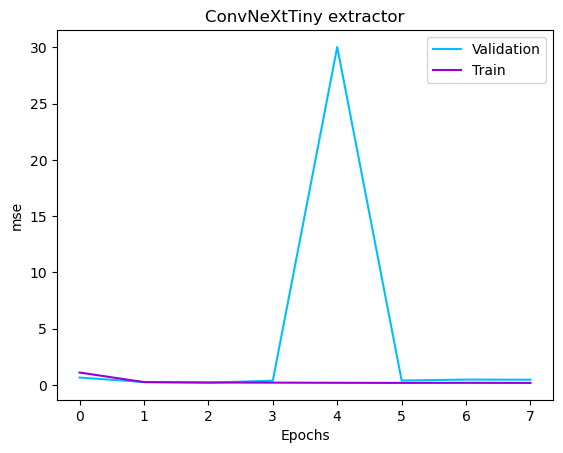

In [149]:
# visualize training metrics
plt.plot(history.history['val_mse'], color='deepskyblue')
plt.plot(history.history['mse'], color='darkviolet')
plt.title('ConvNeXtTiny extractor')
plt.legend(['Validation', 'Train'])
plt.xlabel('Epochs')
plt.ylabel('mse')
plt.show()


In [ ]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, 20 - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

In [150]:
# Оценка модели
results = model.evaluate(test_generator)
print(f"Test accuracy: {results[1] * 100:.2f}%")

39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - loss: 0.1853 - mse: 0.1853
Test accuracy: 17.25%


Вывод: Точность решения задачи классификации на тестовой выборке составила:

17.25%